# ResNet50 - DeepFake Detection

In [2]:
# Imports here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
import torch
import torch.nn.functional as F

from torch import nn
from torch import optim
from tqdm import tqdm 
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix

# DeepFake detection dataset

In [3]:
#training, validation, and test data

train_dir = r"E:\BigdataandAI\sem2\AI2 Project work\data for experiments\split_dataset\train"
valid_dir = r"E:\BigdataandAI\sem2\AI2 Project work\data for experiments\split_dataset\val"
test_dir = r"E:\BigdataandAI\sem2\AI2 Project work\data for experiments\split_dataset\test"

In [4]:
# Define transforms for the training, validation, and testing sets
training_transforms = transforms.Compose([transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

testing_transforms = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)
validation_dataset = datasets.ImageFolder(valid_dir, transform=validation_transforms)
testing_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)
validate_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=32)

# Design & architecture

In [5]:
# Load pretrained ResNet50 Model

model = models.resnet50(pretrained=True)


C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False

In [7]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2), 
    nn.Sigmoid() # For using NLLLoss()
)

# Define loss function with Adam optimizer

In [8]:
# Loss function and gradient descent

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.00001)


# Model training

In [9]:
# Define training accuracy & loss 

train_accu = []
train_losses = []

# Function for defining the train
def train(epoch):
    
    print('\nEpoch : %d'%epoch)
    model.train()
 
    running_loss=0
    correct=0
    total=0
    CM=0
 
    for data in tqdm(train_loader):

        inputs,labels=data[0],data[1]
     
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=loss_fn(outputs,labels)
        loss.backward()
        optimizer.step()
 
        running_loss += loss.item()
     
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        CM+=confusion_matrix(labels, predicted,labels=[0,1])
      
        tn=int(CM[0][0])
        tp=int(CM[1][1])
        fp=int(CM[0][1])
        fn=int(CM[1][0])
    train_loss=running_loss/len(train_loader)
    accu=100.*correct/total
    sensitivity=tp/(tp+fn)
    precision=tp/(tp+fp)
   
    train_accu.append(accu)
    train_losses.append(train_loss)
    
    # Print performance metric values
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))
    print('- Sensitivity : ',(tp/(tp+fn))*100)
    print('- Specificity : ',(tn/(tn+fp))*100)
    print('- Precision: ',(tp/(tp+fp))*100)
    print('Confusion Matrix', CM)

In [10]:
# Define validation accuracy & loss

eval_losses=[]
eval_accu=[]
 
# Function for defining the validation
def validation(epoch):
    
    model.eval()
 
    running_loss=0
    correct=0
    total=0
    CM=0
 
    with torch.no_grad():
        for data in tqdm(validate_loader):
            
            images,labels=data[0],data[1]
            outputs=model(images)
 
            loss= loss_fn(outputs,labels)
            running_loss+=loss.item()
       
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            CM+=confusion_matrix(labels, predicted, labels=[0,1])
   
        tn=int(CM[0][0])
        tp=int(CM[1][1])
        fp=int(CM[0][1])
        fn=int(CM[1][0])
    validate_loss=running_loss/len(validate_loader)
    accu=100.*correct/total
    sensitivity=tp/(tp+fn)
    precision=tp/(tp+fp)
 
    eval_losses.append(validate_loss)
    eval_accu.append(accu)
 
    # Print performance metric values
    print('Validate Loss: %.3f | Accuracy: %.3f'%(validate_loss,accu))
    print('- Sensitivity : ',(tp/(tp+fn))*100)
    print('- Specificity : ',(tn/(tn+fp))*100)
    print('- Precision: ',(tp/(tp+fp))*100)
    print('Confusion Matrix', CM)

In [11]:
# Training the model for 15 epochs 

epochs=15
for epoch in range(1,epochs+1): 
    
    train(epoch)
    validation(epoch)

  0%|                                                                                          | 0/487 [00:00<?, ?it/s]


Epoch : 1


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Train Loss: 0.665 | Accuracy: 58.940
- Sensitivity :  98.33822091886609
- Specificity :  1.887385970430953
- Precision:  59.20742872089981
Confusion Matrix [[ 120 6238]
 [ 153 9054]]


  0%|                                                                                          | 0/487 [00:00<?, ?it/s]

Validate Loss: 0.645 | Accuracy: 59.259
- Sensitivity :  100.0
- Specificity :  0.2518891687657431
- Precision:  59.2173017507724
Confusion Matrix [[   2  792]
 [   0 1150]]

Epoch : 2


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Train Loss: 0.631 | Accuracy: 67.061
- Sensitivity :  96.13337677853806
- Specificity :  24.960679458949357
- Precision:  64.97577448245485
Confusion Matrix [[1587 4771]
 [ 356 8851]]


  0%|                                                                                          | 0/487 [00:00<?, ?it/s]

Validate Loss: 0.609 | Accuracy: 69.444
- Sensitivity :  97.73913043478261
- Specificity :  28.463476070528966
- Precision:  66.43026004728132
Confusion Matrix [[ 226  568]
 [  26 1124]]

Epoch : 3


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Train Loss: 0.604 | Accuracy: 73.492
- Sensitivity :  91.54990767893993
- Specificity :  47.34193142497641
- Precision:  71.57170756559395
Confusion Matrix [[3010 3348]
 [ 778 8429]]


  0%|                                                                                          | 0/487 [00:00<?, ?it/s]

Validate Loss: 0.582 | Accuracy: 75.720
- Sensitivity :  96.0
- Specificity :  46.34760705289673
- Precision:  72.15686274509804
Confusion Matrix [[ 368  426]
 [  46 1104]]

Epoch : 4


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Train Loss: 0.584 | Accuracy: 75.612
- Sensitivity :  88.98664059954382
- Specificity :  56.244101918842404
- Precision:  74.65148063781322
Confusion Matrix [[3576 2782]
 [1014 8193]]


  0%|                                                                                          | 0/487 [00:00<?, ?it/s]

Validate Loss: 0.563 | Accuracy: 78.704
- Sensitivity :  93.82608695652173
- Specificity :  56.80100755667507
- Precision:  75.8790436005626
Confusion Matrix [[ 451  343]
 [  71 1079]]

Epoch : 5


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Train Loss: 0.569 | Accuracy: 76.351
- Sensitivity :  87.9874008906267
- Specificity :  59.49984271783579
- Precision:  75.88047958036718
Confusion Matrix [[3783 2575]
 [1106 8101]]


  0%|                                                                                          | 0/487 [00:00<?, ?it/s]

Validate Loss: 0.549 | Accuracy: 79.681
- Sensitivity :  91.47826086956522
- Specificity :  62.59445843828715
- Precision:  77.98369162342476
Confusion Matrix [[ 497  297]
 [  98 1052]]

Epoch : 6


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Train Loss: 0.559 | Accuracy: 77.013
- Sensitivity :  86.77093515803193
- Specificity :  62.881409248191254
- Precision:  77.19586433471834
Confusion Matrix [[3998 2360]
 [1218 7989]]


  0%|                                                                                          | 0/487 [00:00<?, ?it/s]

Validate Loss: 0.538 | Accuracy: 80.350
- Sensitivity :  91.21739130434783
- Specificity :  64.6095717884131
- Precision:  78.87218045112782
Confusion Matrix [[ 513  281]
 [ 101 1049]]

Epoch : 7


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Train Loss: 0.552 | Accuracy: 77.649
- Sensitivity :  87.22710980775497
- Specificity :  63.77791758414596
- Precision:  77.7143410102574
Confusion Matrix [[4055 2303]
 [1176 8031]]


  0%|                                                                                          | 0/487 [00:00<?, ?it/s]

Validate Loss: 0.534 | Accuracy: 79.835
- Sensitivity :  84.08695652173913
- Specificity :  73.67758186397985
- Precision:  82.22789115646259
Confusion Matrix [[585 209]
 [183 967]]

Epoch : 8


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Train Loss: 0.541 | Accuracy: 78.664
- Sensitivity :  86.86868686868688
- Specificity :  66.78200692041523
- Precision:  79.10979228486646
Confusion Matrix [[4246 2112]
 [1209 7998]]


  0%|                                                                                          | 0/487 [00:00<?, ?it/s]

Validate Loss: 0.530 | Accuracy: 80.041
- Sensitivity :  82.69565217391305
- Specificity :  76.19647355163728
- Precision:  83.42105263157895
Confusion Matrix [[605 189]
 [199 951]]

Epoch : 9


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Train Loss: 0.536 | Accuracy: 78.773
- Sensitivity :  86.41251221896383
- Specificity :  67.70997168921045
- Precision:  79.48846038565291
Confusion Matrix [[4305 2053]
 [1251 7956]]


  0%|                                                                                          | 0/487 [00:00<?, ?it/s]

Validate Loss: 0.523 | Accuracy: 79.733
- Sensitivity :  84.43478260869566
- Specificity :  72.92191435768261
- Precision:  81.87183811129847
Confusion Matrix [[579 215]
 [179 971]]

Epoch : 10


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Train Loss: 0.533 | Accuracy: 78.542
- Sensitivity :  86.14097968936679
- Specificity :  67.5369613085876
- Precision:  79.3496748374187
Confusion Matrix [[4294 2064]
 [1276 7931]]


  0%|                                                                                          | 0/487 [00:00<?, ?it/s]

Validate Loss: 0.517 | Accuracy: 80.041
- Sensitivity :  84.08695652173913
- Specificity :  74.18136020151134
- Precision:  82.5085324232082
Confusion Matrix [[589 205]
 [183 967]]

Epoch : 11


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Train Loss: 0.526 | Accuracy: 79.557
- Sensitivity :  86.57543173672207
- Specificity :  69.39289084617805
- Precision:  80.37713018049814
Confusion Matrix [[4412 1946]
 [1236 7971]]


  0%|                                                                                          | 0/487 [00:00<?, ?it/s]

Validate Loss: 0.514 | Accuracy: 80.247
- Sensitivity :  83.91304347826087
- Specificity :  74.93702770780857
- Precision:  82.90378006872852
Confusion Matrix [[595 199]
 [185 965]]

Epoch : 12


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Train Loss: 0.526 | Accuracy: 78.908
- Sensitivity :  86.16270229173455
- Specificity :  68.4020132117018
- Precision:  79.79279822973245
Confusion Matrix [[4349 2009]
 [1274 7933]]


  0%|                                                                                          | 0/487 [00:00<?, ?it/s]

Validate Loss: 0.510 | Accuracy: 80.556
- Sensitivity :  88.0
- Specificity :  69.77329974811083
- Precision:  80.83067092651757
Confusion Matrix [[ 554  240]
 [ 138 1012]]

Epoch : 13


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Train Loss: 0.520 | Accuracy: 79.364
- Sensitivity :  86.46681872488324
- Specificity :  69.07832651777288
- Precision:  80.19542661428427
Confusion Matrix [[4392 1966]
 [1246 7961]]


  0%|                                                                                          | 0/487 [00:00<?, ?it/s]

Validate Loss: 0.512 | Accuracy: 80.453
- Sensitivity :  82.52173913043478
- Specificity :  77.455919395466
- Precision:  84.13120567375887
Confusion Matrix [[615 179]
 [201 949]]

Epoch : 14


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Train Loss: 0.520 | Accuracy: 79.313
- Sensitivity :  85.69566634082764
- Specificity :  70.06920415224913
- Precision:  80.56775247625855
Confusion Matrix [[4455 1903]
 [1317 7890]]


  0%|                                                                                          | 0/487 [00:00<?, ?it/s]

Validate Loss: 0.510 | Accuracy: 80.710
- Sensitivity :  81.65217391304348
- Specificity :  79.34508816120906
- Precision:  85.13145965548505
Confusion Matrix [[630 164]
 [211 939]]

Epoch : 15


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]

Train Loss: 0.516 | Accuracy: 79.820
- Sensitivity :  86.03236667752797
- Specificity :  70.82415854042151
- Precision:  81.02495908346971
Confusion Matrix [[4503 1855]
 [1286 7921]]


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [03:31<00:00,  3.47s/it]

Validate Loss: 0.508 | Accuracy: 80.504
- Sensitivity :  83.21739130434781
- Specificity :  76.57430730478589
- Precision:  83.72703412073491
Confusion Matrix [[608 186]
 [193 957]]


# Learning curves

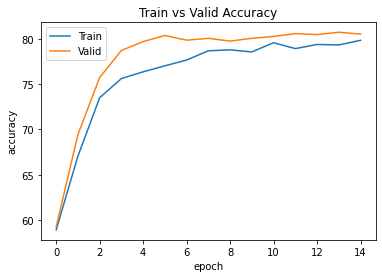

In [12]:
#training & validation accuracy plots

plt.plot(train_accu)
plt.plot(eval_accu)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
 
plt.show()

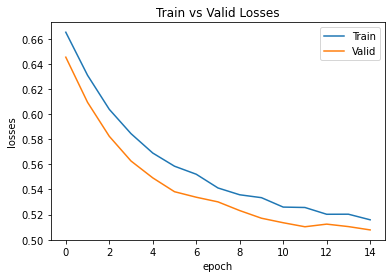

In [13]:
#training & validation loss plots

plt.plot(train_losses)
plt.plot(eval_losses)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
 
plt.show()

In [14]:
def test_accuracy(model, test_loader):

    # Do validation on the test set
    model.eval()

    with torch.no_grad():
    
        accuracy = 0
    
        for images, labels in iter(test_loader):
    
            output = model.forward(images)

            probabilities = torch.exp(output)
        
            equality = (labels.data == probabilities.max(dim=1)[1])
        
            accuracy += equality.type(torch.FloatTensor).mean()
        
        print("Test Accuracy: {}".format(accuracy/len(test_loader)))    
        
        
test_accuracy(model, test_loader)

Test Accuracy: 0.8278688788414001


# Testing model

In [21]:
#Defining test function with test results

def test_accuracy(model, test_loader):

    # Do validation on the test set
    model.eval()

    with torch.no_grad():
    
        accuracy = 0
        CM=0
    
        for images, labels in iter(test_loader):
    
            output = model.forward(images)

            probabilities = torch.exp(output)
            preds = torch.argmax(output.data, 1)
            
            CM+=confusion_matrix(labels, preds, labels=[0,1])
        
            equality = (labels.data == probabilities.max(dim=1)[1])
        
            accuracy += equality.type(torch.FloatTensor).mean()
            tn=CM[0][0]
            tp=CM[1][1]
            fp=CM[0][1]
            fn=CM[1][0]
        sensitivity=tp/(tp+fn)
        precision=tp/(tp+fp)
        f1_score=((2*sensitivity*precision)/(sensitivity+precision))
        
        print("Test Accuracy: {}".format(accuracy/len(test_loader)))     
        print('Sensitivity : ',(tp/(tp+fn))*100)
        print('Specificity : ',(tn/(tn+fp))*100)
        print('Precision: ',(tp/(tp+fp))*100)
        print('Confusion Matrix', CM)
        print('F1-score', f1_score)

        
test_accuracy(model, test_loader)

Test Accuracy: 0.8278688788414001
Sensitivity :  85.59027777777779
Specificity :  78.64321608040201
Precision:  85.29411764705883
Confusion Matrix [[626 170]
 [166 986]]
F1-score 0.854419410745234


# Saving the model

In [ ]:
# Save the checkpoint

def save_checkpoint(model):

    model.class_to_idx = training_dataset.class_to_idx

    checkpoint = {'arch': "resnet50",
                  'class_to_idx': model.class_to_idx,
                  'model_state_dict': model.state_dict()
                 }

    torch.save(checkpoint, 'DF_pytorch_model1_resnet50_15epochs_lr0.00001.pth ')
    
save_checkpoint(model)  